In [5]:
from __future__ import division
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

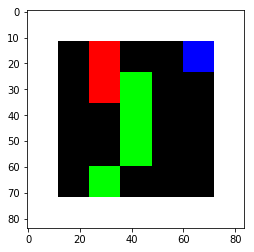

In [6]:
from gridworld import gameEnv

env = gameEnv(partial=False, size=5)

In [8]:
env.state.shape

(84, 84, 3)

This is the game we'll be working on. The player can move the blue square up, down, left or right. The point of the game is to get to the green square (+1 reward) and avoid the red square (-1 reward). Blocks are randomized

## Implementing the network

In [73]:
class Qnetwork():
    def __init__(self, final_layer_size):
        # The input image of the game is 84 x 84 x 3 (RGB) 
        inputs = Input(shape=env.state.shape())

        # There will be four layers of convolutions performed on the image input
        # A convolution take a portion of an input and matrix multiplies
        # a filter on the portion to get a new input (see below)
        self.model = Conv2D(
            filters=32,
            kernel_size=[8,8],
            strides=[4,4],
            padding="valid")(inputs)
        self.model = Conv2D(
            filters=64,
            kernel_size=[4,4],
            strides=[2,2],
            padding="valid")(self.model)
        self.model = Conv2D(
            filters=64,
            kernel_size=[3,3],
            strides=[1,1],
            padding="valid")(self.model)
        self.model = Conv2D(
            filters= final_layer_size,
            kernel_size=[7,7],
            strides=[1,1],
            padding="valid")(self.model)

        
        # We then separate the final convolution layer into an advantage and value
        # stream. The value function is how well off you are in a given state.
        # The advantage is the how much better off you are after making a particular
        # move. Q is the value function of a state after a given action.
        # Advantage(state, action) = Q(state, action) - Value(state)
        self.stream_AC, self.stream_VC = tf.split(split_dim=3,num_split=2,value=self.conv4)
        
        # We then flatten the advantage and value functions
        self.stream_AC = slim.flatten(self.stream_AC)
        self.stream_VC = slim.flatten(self.stream_VC)
        
        # We define weights for our advantage and value layers. We will train these
        # layers so the matmul will match the expected value and advantage from play
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([final_layer_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([final_layer_size//2,1]))
        self.Advantage = tf.matmul(self.stream_AC, self.AW)
        self.Value = tf.matmul(self.stream_VC, self.VW)
        
        # To get the Q output, we need to add the value to the advantage.
        # The advantage to be evaluated will bebased on how good the action
        # is based on the average advantage of that state
        self.Q_out = self.Value + tf.subtract(self.Advantage,
                                              tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))

        # Our prediction is then the highest Q output
        self.predict = tf.argmax(self.Q_out, 1)
        
        # We need to keep track of our losses (sum of square differences)
        self.target_Q = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions,dtype=tf.float32)
        
        # Final Q values that we want to learn from
        self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), axis=1)
        
        # Calculating errors and training
        self.td_error = tf.square(self.target_Q - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.update_model = self.trainer.minimize(self.loss)

## How convolutions work
![How convolutions work](img/convolutions.gif)

## Experience Replay

This class allows us to store experiences and sample them randomly for learning

In [135]:
class ExperienceReplay:
    def __init__(self,buffer_size=50000):
        # Buffer will contain [state,action,reward,next_state,done]
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        # Extend the stored experiences
        self.buffer.extend(experience)
        # Keep the last buffer_size number of experiences
        self.buffer = self.buffer[-self.buffer_size:]
        
    def sample(self, size):
        sample_idxs = np.random.randint(len(self.buffer),size=size)
        sample_output = [self.buffer[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output,(size,-1))
        return sample_output

In [179]:
def process_state(states):
    # This will flatten our state to be used in our Q network
    return states.flatten()

def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

# def update_target_graph(tf_vars, tau):
#     num_vars = len(tf_vars)
#     # tf_vars contains both our primary and target graph
#     # [primary..., target...]
#     # target graph starts half way through the list
#     target_start = num_vars // 2
#     op_holder = []
#     for idx, var in enumerate(tf_vars[:target_start]):
#         # ??
# #         updated_val = (var.value() * tau) + \
#         updated_val = (var * tau) + \
#             ((1 - tau) * tf_vars[target_start + idx])
# #             ((1 - tau) * tf_vars[target_start + idx].value())
# #         updated_graph = tf_vars[target_start + idx]
#     #         updated_graph.assign(updated_val)
#         op_holder.append(updated_val)
#     return op_holder

def update_target(op_holder, sess):
    for op in op_holder:
        sess.run(op)

In [180]:
update_target_graph(np.arange(10),0.1)

[4.5, 5.5, 6.5, 7.5, 8.5]

## Training the network

In [182]:
batch_size = 32 # How many experiences to use for each training step
update_freq = 4 # How often to perform a training step
y = 0.99 # Discount factor
prob_random_start = 1 # Starting chance of random action
prob_random_end = 0.1 # Ending chance of random action
annealing_steps = 10000. # Steps of training to reduce from start_e -> end_e
num_episodes = 10000 # How many episodes of game environment to train
pre_train_episodes = 100 # Number of episodes of random actions
max_num_step = 50 # Maximum allowed episode length
load_model = False # Whether to load a saved model
path = "./dqn" # Path to save our model to
final_layer_size = 512 # Size of the final convolution layer before 
                       # splitting into Advantage and Value streams
tau = 0.001 # Rate to update target network toward primary network

In [ ]:
# Reset everything
tf.reset_default_graph()

# Setup our Q-networks
main_qn = Qnetwork(final_layer_size)
target_qn = Qnetwork(final_layer_size)

# Initializer
init = tf.global_variables_initializer()

# Saver to save our neural network
saver = tf.train.Saver()

# Variables we'll be training in the neural network
trainables = tf.trainable_variables()

# Returns our variables
target_ops = updateTargetGraph(trainables, tau)

# Setup our experience replay
experience_replay = ExperienceReplay()

# We'll begin by acting complete randomly. As we gain experience and improve,
# we will begin reducing the probability of acting randomly, and instead
# take the actions that our Q network suggests
prob_random = prob_random_start
prob_random_drop = (prob_random_start - prob_random_end) / annealing_steps

num_steps = [] # Tracks number of steps per episode
rewards = [] # Tracks rewards per episode
total_steps = 0 # Tracks cumulative steps taken in training

print_every = 50 # How often to print status
save_every = 10 # How often to save

# Setup path for saving
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print("Loading model...")
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    
    for num_episode in range(num_episodes):
        # Create an experience replay for the current episode
        episode_buffer = ExperienceReplay()
        
        # Get the game state from the environment
        state = env.reset()
        
        # Process the game state so it can be used in our Q network
        state = process_state(state)
        
        done = False # Game is complete
        sum_rewards = 0 # Running sum of rewards in episode
        cur_step = 0 # Running sum of number of steps taken in episode
        
        while cur_step < max_num_step:
            cur_step += 1
            total_steps += 1
            
            if np.random.rand() < prob_random or \
                num_episode < pre_train_episodes:
                    # Act randomly based on prob_random or if we
                    # have not accumulated enough pre_train steps
                    action = np.random.randint(env.actions)
            else:
                # Decide what action to take from the Q network
                feed_dict = {main_qn.scalar_input: [state]}
                action = sess.run(main_qn.predict,
                                  feed_dict=feed_dict)
                action = action[0]
            
            # Take the action and retrieve the next state, reward and done
            next_state, reward, done = env.step(action)
            
            # Process next state
            next_state = process_state(next_state)
            
            # Setup the episode to be stored in the episode buffer
            episode = np.array([state,action,reward,next_state,done])
            episode = episode.reshape(1,-1)
            episode_buffer.add(episode)
            
            sum_rewards += reward
            state = next_state

            if num_episode > pre_train_episodes:
                if prob_random > prob_random_end:
                    prob_random -= prob_random_drop
                
                if total_steps % update_freq == 0:
                    # Train batch is [[state,action,reward,next_state,done],...]
                    train_batch = experience_replay.sample(batch_size)
                    # Separate the batch into its components
                    train_state, train_action, train_reward, \
                        train_next_state, train_done = train_batch.T
                    
                    # Convert state and next_state from ???
                    train_state = np.vstack(train_state)
                    train_next_state = np.vstack(train_next_state)
                    
                    # Our predictions (actions to take) from the main Q network
                    train_next_state_action = sess.run(
                        main_qn.predict,
                        feed_dict = { 
                          main_qn.scalar_input: train_state
                        })
                    
                    # The Q values from our target network from the next state
                    train_next_state = sess.run(target_qn.Q_out,
                                 feed_dict = {
                                     target_qn.scalar_input: train_next_state
                                 })
                    
                    # Tells us whether game over or not
                    # We will multiply our gradients by this value
                    # to ensure we don't train on the last move
                    train_gameover = train_done == 0
                    
                    # Q value of the next state based on action
                    train_next_state_values = train_next_state[range(batch_size), train_next_state_action]
                    
                    # Reward from the action chosen in the train batch
                    target_q = train_reward + (y * train_next_state_values * train_gameover)
                    
                    _ = sess.run(main_qn.update_model, \
                                feed_dict={
                                    main_qn.scalar_input: train_state,
                                    main_qn.target_Q: target_q,
                                    main_qn.actions: train_action
                                })
                    
                    update_target(target_ops, sess)
            if done:
                break
        experience_replay.add(episode_buffer.buffer)
        num_steps.append(cur_step)
        rewards.append(sum_rewards)
        
        if num_episode % save_every == 0:
            saver.save(sess, path + "/model-{}.ckpt".format(num_episode))
        if num_episode % print_every == 0:
            print("Num episode: {} Mean reward: {:0.4f}".format(
                num_episode, np.mean(rewards[-print_every:])
            ))

Num episode: 0 Mean reward: 2.0000
Num episode: 50 Mean reward: 1.8200
Num episode: 100 Mean reward: 1.5400


Loading model...
step: 1 action: 1 reward: 0.0 total rewards: 0.0
step: 2 action: 2 reward: 0.0 total rewards: 0.0
step: 3 action: 2 reward: -1.0 total rewards: -1.0
step: 4 action: 0 reward: 0.0 total rewards: -1.0
step: 5 action: 2 reward: 0.0 total rewards: -1.0
step: 6 action: 2 reward: 0.0 total rewards: -1.0
step: 7 action: 2 reward: 0.0 total rewards: -1.0
step: 8 action: 2 reward: 0.0 total rewards: -1.0
step: 9 action: 2 reward: 0.0 total rewards: -1.0
step: 10 action: 2 reward: 0.0 total rewards: -1.0
step: 11 action: 2 reward: 0.0 total rewards: -1.0
step: 12 action: 2 reward: 0.0 total rewards: -1.0
step: 13 action: 2 reward: 0.0 total rewards: -1.0
step: 14 action: 2 reward: 0.0 total rewards: -1.0
step: 15 action: 2 reward: 0.0 total rewards: -1.0
step: 16 action: 2 reward: 0.0 total rewards: -1.0
step: 17 action: 2 reward: 0.0 total rewards: -1.0
step: 18 action: 2 reward: 0.0 total rewards: -1.0
step: 19 action: 2 reward: 0.0 total rewards: -1.0
step: 20 action: 2 rewar

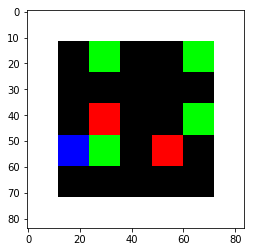

In [169]:
with tf.Session() as sess:
    sess.run(init)
    print("Loading model...")
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)
    done = False
    num_step = 0
    sum_rewards = 0
    state = process_state(env.reset())

    while not done and num_step < max_num_step:
        num_step += 1
        action = sess.run(main_qn.predict, feed_dict = {
            main_qn.scalar_input: [state]})[0]
        next_state, reward, done = env.step(action)
        sum_rewards += reward
        print("step: {} action: {} reward: {} total rewards: {}".format(
            num_step,action,reward,sum_rewards))
        plt.imshow(env.renderEnv())
        
        state = process_state(next_state)
        

In [165]:
env.

50

In [162]:
env.renderEnv().shape

(84, 84, 3)